# Лабораторная работа 1. Нейронные сети.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за всю работу — 15 баллов
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировкам
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.

### Правила сдачи
Выполненную работу следует отправить в систему Anytask. Более подробно о системе можно почитать на странице курса. Название отправляемого файла должно иметь следующий формат: Surname_Name_Group_NN.ipynb, где NN — номер лабораторной работы. Например, Kozlova_Anna_CS_01.ipynb.

# Часть 1. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [1]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

Using Theano backend.
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

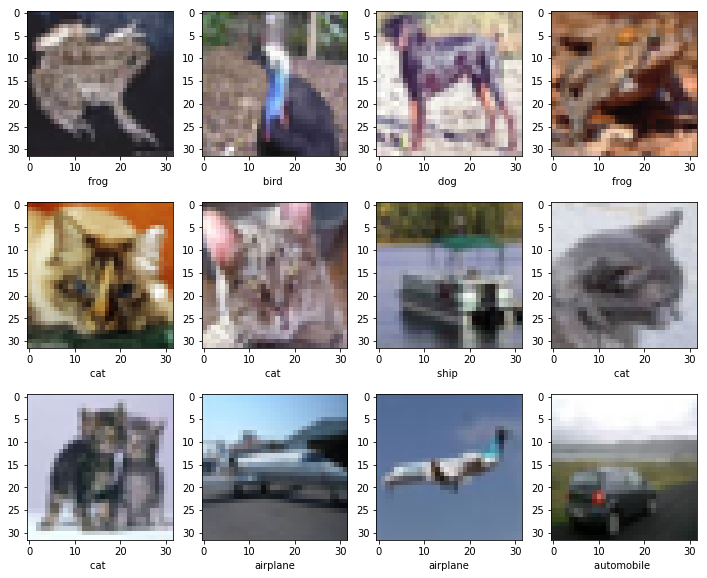

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [3]:
X_train = X_train/255 # YOUR CODE
X_val = X_val/255 # YOUR CODE
X_test = X_test/255 # YOUR CODE

Исполните код ниже для проверки, что все выполнено корректно.

In [4]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

In [5]:
import keras, keras.layers as L

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation

Создайте полносвязную сеть:

In [10]:
model = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax'),
])

In [11]:
dummy_pred = model.predict_proba(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

20/20 [==============================] - 0s
Успех!


## Обучение сети

**Задание 1.1 (1 балл)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [8]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, validation_data=[X_val, y_val])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 4s - loss: 1.9130 - sparse_categorical_accuracy: 0.3183 - val_loss: 1.7811 - val_sparse_categorical_accuracy: 0.3640
Epoch 2/10
40000/40000 [==============================] - 3s - loss: 1.7397 - sparse_categorical_accuracy: 0.3852 - val_loss: 1.6991 - val_sparse_categorical_accuracy: 0.4080
Epoch 3/10
40000/40000 [==============================] - 3s - loss: 1.6635 - sparse_categorical_accuracy: 0.4135 - val_loss: 1.6638 - val_sparse_categorical_accuracy: 0.4153
Epoch 4/10
40000/40000 [==============================] - 3s - loss: 1.6141 - sparse_categorical_accuracy: 0.4330 - val_loss: 1.6146 - val_sparse_categorical_accuracy: 0.4258
Epoch 5/10
40000/40000 [==============================] - 3s - loss: 1.5771 - sparse_categorical_accuracy: 0.4452 - val_loss: 1.5910 - val_sparse_categorical_accuracy: 0.4292
Epoch 6/10
40000/40000 [==============================] - 3s - loss: 1.5447

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [9]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

 9664/10000 [===========================>..] - ETA: 0s
 Test_acc = 0.4765
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (1 балл)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [36]:
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
model = Sequential([
    ZeroPadding2D((1, 1), input_shape=(32, 32, 3)),
    Conv2D(10, (3, 3), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),    
    Dense(100, activation='relu'),
    Dense(10, activation='softmax'),
])

In [11]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, validation_data=[X_val, y_val])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 21s - loss: 1.9737 - sparse_categorical_accuracy: 0.2897 - val_loss: 1.7864 - val_sparse_categorical_accuracy: 0.3720
Epoch 2/10
40000/40000 [==============================] - 21s - loss: 1.6800 - sparse_categorical_accuracy: 0.4086 - val_loss: 1.5629 - val_sparse_categorical_accuracy: 0.4446
Epoch 3/10
40000/40000 [==============================] - 21s - loss: 1.5252 - sparse_categorical_accuracy: 0.4584 - val_loss: 1.4853 - val_sparse_categorical_accuracy: 0.4698
Epoch 4/10
40000/40000 [==============================] - 20s - loss: 1.4302 - sparse_categorical_accuracy: 0.4907 - val_loss: 1.4178 - val_sparse_categorical_accuracy: 0.4930
Epoch 5/10
40000/40000 [==============================] - 20s - loss: 1.3584 - sparse_categorical_accuracy: 0.5183 - val_loss: 1.3564 - val_sparse_categorical_accuracy: 0.5136
Epoch 6/10
40000/40000 [==============================] - 20s - loss: 

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [12]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

 9984/10000 [============================>.] - ETA: 0s
 Test_acc = 0.5613
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций. 

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

In [6]:
import os
from keras.callbacks import LearningRateScheduler, Callback
import matplotlib
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from time import time
import sys

class GlobalWotcher(Callback):

    def __init__(self, acc=False, react_time=600, dump_p=1000,
                 base_path="./"):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = None
        self.val_acc = None
        self.acc = acc
        self.train_acc = []
        self.val_acc = []
        self.react_time = react_time
        self.dump_period = dump_p
        self.base_path = base_path
        if not os.path.exists(self.base_path):
            os.makedirs(self.base_path)

    def on_epoch_begin(self, epoch, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        self.cur_time = time()
        self.epoch += 1

        self.train_loss.append(logs.get('loss', None))
        self.val_loss.append(logs.get('val_loss', None))
        self.train_acc.append(logs.get('sparse_categorical_accuracy', None))
        self.val_acc.append(logs.get('val_sparse_categorical_accuracy', None))

        if self.cur_time - self.last_time >= self.react_time:
            self.dump_calculations()
            self.last_time = time()

        if self.epoch % self.dump_period == 0:
            self.dump_model()

    def on_train_begin(self, logs={}):
        self.last_time = time()
        self.epoch = 0

    def dump_model(self):
        model.save_weights(os.path.join(self.base_path,
                                        'model_epoch={}.hdf5'.format(self.epoch)),
                           overwrite=True)
        sys.stdout.flush()
        print('\n######## Model Dumped ########')

    def dump_calculations(self):
        np.save(os.path.join(self.base_path, 'dump_train_loss'),
                np.asarray(self.train_loss))
        np.save(os.path.join(self.base_path, 'dump_val_loss'),
                np.asarray(self.val_loss))
        if self.acc:
            np.save(os.path.join(self.base_path, 'dump_train_acc'),
                    np.asarray(self.train_acc))
            np.save(os.path.join(self.base_path, 'dump_val_acc'),
                    np.asarray(self.val_acc))

    def on_train_end(self, logs={}):
        tstamp = datetime.strftime(datetime.now(), "%Y-%m-%d_%H-%M")

        model.save_weights(os.path.join(self.base_path,
                                        'model_epoch={}_({}).hdf5'.format(self.epoch, tstamp)),
                           overwrite=True)

        """plt.figure(figsize=(15, 10))
        plt.plot(range(1, len(self.train_loss) + 1), self.train_loss,
                 'r--', linewidth=3.0)
        plt.plot(range(1, len(self.train_loss) + 1), self.val_loss,
                 'g--', linewidth=3.0)
        plt.xlim(1, len(self.train_loss))
        plt.xlabel('epoch #')
        plt.ylabel('loss')
        plt.grid(True)
        plt.savefig(os.path.join(self.base_path,
                                 './loss_train-val_({}).png'.format(tstamp)))
        np.save(os.path.join(self.base_path, 'train_loss_({})'.format(tstamp)),
                np.asarray(self.train_loss))
        np.save(os.path.join(self.base_path, 'val_loss_({})'.format(tstamp)),
                np.asarray(self.val_loss))"""
        if self.acc:
            plt.figure(figsize=(7, 5))
            plt.plot(range(1, len(self.train_acc) + 1),
                     self.train_acc, 'r--', linewidth=3.0, label='train')
            plt.plot(range(1, len(self.val_acc) + 1),
                     self.val_acc, 'g--', linewidth=3.0, label='val')
            plt.xlim(1, len(self.train_acc))
            plt.xlabel('epoch #')
            plt.ylabel('accuracy')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(self.base_path,
                                     './acc_train-val_({}).png'.format(tstamp)))
            np.save(os.path.join(self.base_path, 'train_acc_({})'.format(tstamp)),
                    np.asarray(self.train_acc))
            np.save(os.path.join(self.base_path, 'val_acc_({})'.format(tstamp)),
                    np.asarray(self.val_acc))

**Задание 1.3 (0.5 балла)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Лучше всего работает adam

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 20s - loss: 1.9273 - sparse_categorical_accuracy: 0.3159 - val_loss: 1.7840 - val_sparse_categorical_accuracy: 0.3644
Epoch 2/10
40000/40000 [==============================] - 19s - loss: 1.6956 - sparse_categorical_accuracy: 0.4056 - val_loss: 1.6111 - val_sparse_categorical_accuracy: 0.4235
Epoch 3/10
40000/40000 [==============================] - 19s - loss: 1.5413 - sparse_categorical_accuracy: 0.4564 - val_loss: 1.4521 - val_sparse_categorical_accuracy: 0.4839
Epoch 4/10
40000/40000 [==============================] - 20s - loss: 1.4177 - sparse_categorical_accuracy: 0.4985 - val_loss: 1.3680 - val_sparse_categorical_accuracy: 0.5140
Epoch 5/10
40000/40000 [==============================] - 20s - loss: 1.3389 - sparse_categorical_accuracy: 0.5285 - val_loss: 1.3072 - val_sparse_categorical_accuracy: 0.5393
Epoch 6/10
40000/40000 [==============================] - 20s - loss: 

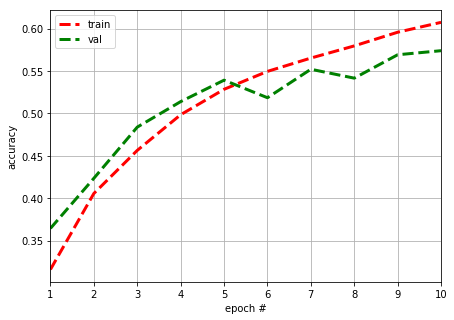

In [38]:
model = Sequential([
    ZeroPadding2D((1, 1), input_shape=(32, 32, 3)),
    Conv2D(10, (3, 3), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),    
    Dense(100, activation='relu'),
    Dense(10, activation='softmax'),
])

gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")

model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, validation_data=[X_val, y_val], callbacks=[gw])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 20s - loss: 1.6147 - sparse_categorical_accuracy: 0.4205 - val_loss: 1.3681 - val_sparse_categorical_accuracy: 0.5086
Epoch 2/10
40000/40000 [==============================] - 20s - loss: 1.2897 - sparse_categorical_accuracy: 0.5366 - val_loss: 1.2783 - val_sparse_categorical_accuracy: 0.5515
Epoch 3/10
40000/40000 [==============================] - 20s - loss: 1.1722 - sparse_categorical_accuracy: 0.5854 - val_loss: 1.1903 - val_sparse_categorical_accuracy: 0.5786
Epoch 4/10
40000/40000 [==============================] - 20s - loss: 1.0748 - sparse_categorical_accuracy: 0.6177 - val_loss: 1.1822 - val_sparse_categorical_accuracy: 0.5871
Epoch 5/10
40000/40000 [==============================] - 20s - loss: 0.9863 - sparse_categorical_accuracy: 0.6534 - val_loss: 1.1783 - val_sparse_categorical_accuracy: 0.5880
Epoch 6/10
40000/40000 [==============================] - 20s - loss: 

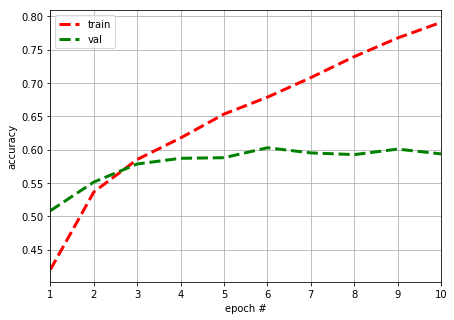

In [40]:
from keras import optimizers
model = Sequential([
    ZeroPadding2D((1, 1), input_shape=(32, 32, 3)),
    Conv2D(10, (3, 3), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),    
    Dense(100, activation='relu'),
    Dense(10, activation='softmax'),
])
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, validation_data=[X_val, y_val], callbacks=[gw])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 26s - loss: 1.5105 - sparse_categorical_accuracy: 0.4671 - val_loss: 1.2926 - val_sparse_categorical_accuracy: 0.5498
Epoch 2/10
40000/40000 [==============================] - 31s - loss: 1.2236 - sparse_categorical_accuracy: 0.5724 - val_loss: 1.1956 - val_sparse_categorical_accuracy: 0.5925
Epoch 3/10
40000/40000 [==============================] - 31s - loss: 1.1219 - sparse_categorical_accuracy: 0.6105 - val_loss: 1.1540 - val_sparse_categorical_accuracy: 0.6003
Epoch 4/10
40000/40000 [==============================] - 31s - loss: 1.0462 - sparse_categorical_accuracy: 0.6352 - val_loss: 1.1401 - val_sparse_categorical_accuracy: 0.6041
Epoch 5/10
40000/40000 [==============================] - 31s - loss: 0.9814 - sparse_categorical_accuracy: 0.6559 - val_loss: 1.1203 - val_sparse_categorical_accuracy: 0.6131
Epoch 6/10
40000/40000 [==============================] - 31s - loss: 

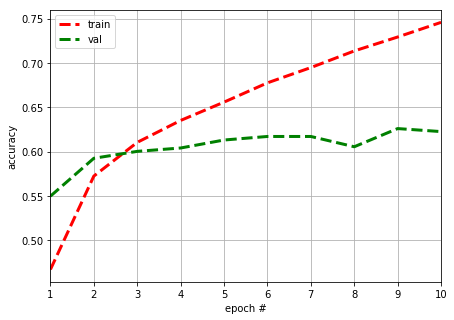

In [42]:
model = Sequential([
    ZeroPadding2D((1, 1), input_shape=(32, 32, 3)),
    Conv2D(10, (3, 3), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),    
    Dense(100, activation='relu'),
    Dense(10, activation='softmax'),
]) 
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, validation_data=[X_val, y_val], callbacks=[gw])

**Задание 1.4 (0.5 балла)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Без нормализации по батчу в данном случае модель ведет себя стабильнее и точность лучше

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 72s - loss: 1.5435 - sparse_categorical_accuracy: 0.4465 - val_loss: 1.4107 - val_sparse_categorical_accuracy: 0.4923
Epoch 2/10
40000/40000 [==============================] - 74s - loss: 1.2758 - sparse_categorical_accuracy: 0.5438 - val_loss: 1.2710 - val_sparse_categorical_accuracy: 0.5470
Epoch 3/10
40000/40000 [==============================] - 75s - loss: 1.1739 - sparse_categorical_accuracy: 0.5806 - val_loss: 1.2859 - val_sparse_categorical_accuracy: 0.5483
Epoch 4/10
40000/40000 [==============================] - 75s - loss: 1.1004 - sparse_categorical_accuracy: 0.6074 - val_loss: 1.2458 - val_sparse_categorical_accuracy: 0.5636
Epoch 5/10
40000/40000 [==============================] - 75s - loss: 1.0394 - sparse_categorical_accuracy: 0.6309 - val_loss: 1.3865 - val_sparse_categorical_accuracy: 0.5178
Epoch 6/10
40000/40000 [==============================] - 74s - loss: 

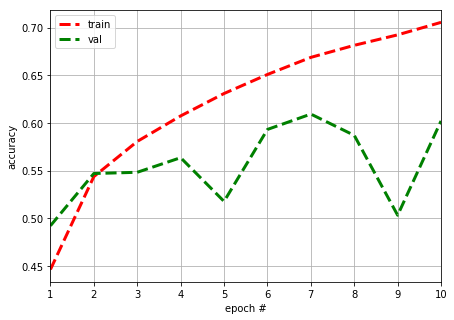

In [45]:
from keras.layers import BatchNormalization

model = Sequential([
    ZeroPadding2D((1, 1), input_shape=(32, 32, 3)),
    Conv2D(10, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),    
    Dense(100, activation='relu'),
    Dense(10, activation='softmax'),
])

gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, validation_data=[X_val, y_val], callbacks=[gw])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 23s - loss: 1.3944 - sparse_categorical_accuracy: 0.5041 - val_loss: 1.3148 - val_sparse_categorical_accuracy: 0.5471
Epoch 2/10
40000/40000 [==============================] - 23s - loss: 1.0881 - sparse_categorical_accuracy: 0.6158 - val_loss: 1.1864 - val_sparse_categorical_accuracy: 0.5767
Epoch 3/10
40000/40000 [==============================] - 24s - loss: 0.9508 - sparse_categorical_accuracy: 0.6666 - val_loss: 1.2120 - val_sparse_categorical_accuracy: 0.5729
Epoch 4/10
40000/40000 [==============================] - 23s - loss: 0.8418 - sparse_categorical_accuracy: 0.7053 - val_loss: 1.3596 - val_sparse_categorical_accuracy: 0.5562
Epoch 5/10
40000/40000 [==============================] - 23s - loss: 0.7561 - sparse_categorical_accuracy: 0.7359 - val_loss: 1.3175 - val_sparse_categorical_accuracy: 0.5835
Epoch 6/10
40000/40000 [==============================] - 23s - loss: 

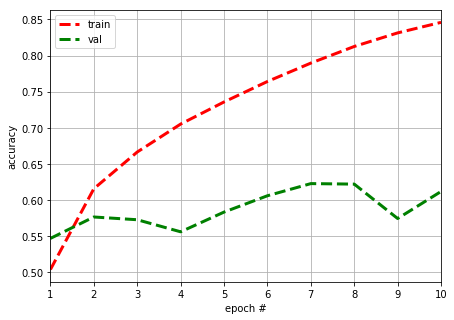

In [46]:
model = Sequential([
    ZeroPadding2D((1, 1), input_shape=(32, 32, 3)),
    Conv2D(10, (3, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),    
    Dense(100),
    BatchNormalization(),
    Activation('relu'),
    Dense(10, activation='softmax'),
])
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, validation_data=[X_val, y_val], callbacks=[gw])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 62s - loss: 1.3715 - sparse_categorical_accuracy: 0.5096 - val_loss: 1.3060 - val_sparse_categorical_accuracy: 0.5409
Epoch 2/10
40000/40000 [==============================] - 59s - loss: 1.0831 - sparse_categorical_accuracy: 0.6166 - val_loss: 1.2502 - val_sparse_categorical_accuracy: 0.5739
Epoch 3/10
40000/40000 [==============================] - 59s - loss: 0.9472 - sparse_categorical_accuracy: 0.6662 - val_loss: 1.2847 - val_sparse_categorical_accuracy: 0.5617
Epoch 4/10
40000/40000 [==============================] - 60s - loss: 0.8504 - sparse_categorical_accuracy: 0.7007 - val_loss: 1.3327 - val_sparse_categorical_accuracy: 0.5467
Epoch 5/10
40000/40000 [==============================] - 60s - loss: 0.7636 - sparse_categorical_accuracy: 0.7304 - val_loss: 1.1091 - val_sparse_categorical_accuracy: 0.6212
Epoch 6/10
40000/40000 [==============================] - 60s - loss: 

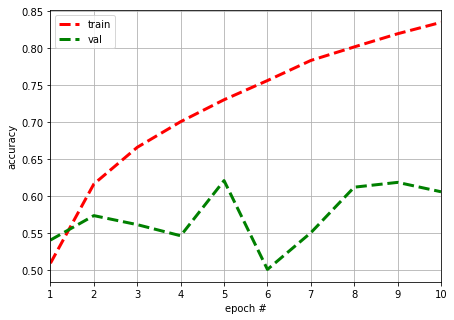

In [47]:
model = Sequential([
    ZeroPadding2D((1, 1), input_shape=(32, 32, 3)),
    Conv2D(10, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),    
    Dense(100),
    BatchNormalization(),
    Activation('relu'),
    Dense(10, activation='softmax'),
])
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, validation_data=[X_val, y_val], callbacks=[gw])

**Задание 1.5 (0.5 балла)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%.

Выберем из предыдущих моделей модель, которая ведет себя наиболее стабильно в зависимости от эпох обучения. У нее же и получилась максимальная точность (уже более 60%), но все равно проведем эксперимент и посмотрим, как зависит точность обучения от размера батча.

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 41s - loss: 1.5657 - sparse_categorical_accuracy: 0.4403 - val_loss: 1.3526 - val_sparse_categorical_accuracy: 0.5220
Epoch 2/10
40000/40000 [==============================] - 50s - loss: 1.2814 - sparse_categorical_accuracy: 0.5477 - val_loss: 1.2291 - val_sparse_categorical_accuracy: 0.5655
Epoch 3/10
40000/40000 [==============================] - 50s - loss: 1.1586 - sparse_categorical_accuracy: 0.5920 - val_loss: 1.1926 - val_sparse_categorical_accuracy: 0.5822
Epoch 4/10
40000/40000 [==============================] - 50s - loss: 1.0838 - sparse_categorical_accuracy: 0.6180 - val_loss: 1.1635 - val_sparse_categorical_accuracy: 0.5919
Epoch 5/10
40000/40000 [==============================] - 50s - loss: 1.0244 - sparse_categorical_accuracy: 0.6399 - val_loss: 1.1544 - val_sparse_categorical_accuracy: 0.6009
Epoch 6/10
40000/40000 [==============================] - 50s - loss: 

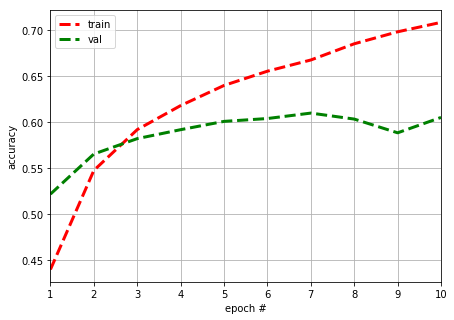

In [48]:
from keras.layers import BatchNormalization, ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense

gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")

model = Sequential([
    ZeroPadding2D((1, 1), input_shape=(32, 32, 3)),
    Conv2D(10, (3, 3), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),    
    Dense(100, activation='relu'),
    Dense(10, activation='softmax'),
]) 
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=16, validation_data=[X_val, y_val], callbacks=[gw])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 26s - loss: 1.5002 - sparse_categorical_accuracy: 0.4655 - val_loss: 1.3368 - val_sparse_categorical_accuracy: 0.5276
Epoch 2/10
40000/40000 [==============================] - 31s - loss: 1.2097 - sparse_categorical_accuracy: 0.5767 - val_loss: 1.2210 - val_sparse_categorical_accuracy: 0.5668
Epoch 3/10
40000/40000 [==============================] - 31s - loss: 1.1018 - sparse_categorical_accuracy: 0.6128 - val_loss: 1.1471 - val_sparse_categorical_accuracy: 0.6001
Epoch 4/10
40000/40000 [==============================] - 31s - loss: 1.0282 - sparse_categorical_accuracy: 0.6401 - val_loss: 1.1231 - val_sparse_categorical_accuracy: 0.6075
Epoch 5/10
40000/40000 [==============================] - 32s - loss: 0.9650 - sparse_categorical_accuracy: 0.6613 - val_loss: 1.1024 - val_sparse_categorical_accuracy: 0.6156
Epoch 6/10
40000/40000 [==============================] - 32s - loss: 

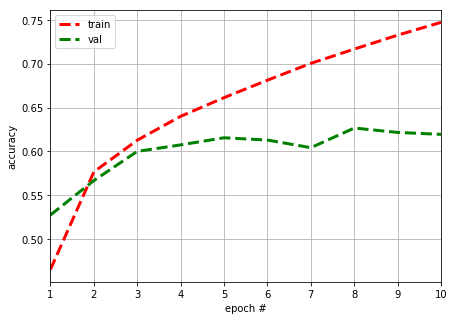

In [49]:
model = Sequential([
    ZeroPadding2D((1, 1), input_shape=(32, 32, 3)),
    Conv2D(10, (3, 3), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),    
    Dense(100, activation='relu'),
    Dense(10, activation='softmax'),
])
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=32, validation_data=[X_val, y_val], callbacks=[gw])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 21s - loss: 1.7071 - sparse_categorical_accuracy: 0.3913 - val_loss: 1.4695 - val_sparse_categorical_accuracy: 0.4761
Epoch 2/10
40000/40000 [==============================] - 28s - loss: 1.3971 - sparse_categorical_accuracy: 0.5043 - val_loss: 1.3477 - val_sparse_categorical_accuracy: 0.5192
Epoch 3/10
40000/40000 [==============================] - 27s - loss: 1.2881 - sparse_categorical_accuracy: 0.5441 - val_loss: 1.2743 - val_sparse_categorical_accuracy: 0.5460
Epoch 4/10
40000/40000 [==============================] - 28s - loss: 1.2185 - sparse_categorical_accuracy: 0.5736 - val_loss: 1.2588 - val_sparse_categorical_accuracy: 0.5568
Epoch 5/10
40000/40000 [==============================] - 28s - loss: 1.1633 - sparse_categorical_accuracy: 0.5917 - val_loss: 1.2849 - val_sparse_categorical_accuracy: 0.5508
Epoch 6/10
40000/40000 [==============================] - 28s - loss: 

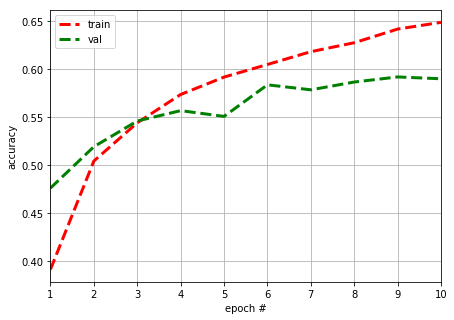

In [50]:
model = Sequential([
    ZeroPadding2D((1, 1), input_shape=(32, 32, 3)),
    Conv2D(10, (3, 3), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),    
    Dense(100, activation='relu'),
    Dense(10, activation='softmax'),
])
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=64, validation_data=[X_val, y_val], callbacks=[gw])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 21s - loss: 1.6815 - sparse_categorical_accuracy: 0.4042 - val_loss: 1.4972 - val_sparse_categorical_accuracy: 0.4653
Epoch 2/10
40000/40000 [==============================] - 20s - loss: 1.4088 - sparse_categorical_accuracy: 0.5032 - val_loss: 1.3501 - val_sparse_categorical_accuracy: 0.5266
Epoch 3/10
40000/40000 [==============================] - 22s - loss: 1.2946 - sparse_categorical_accuracy: 0.5452 - val_loss: 1.2813 - val_sparse_categorical_accuracy: 0.5515
Epoch 4/10
40000/40000 [==============================] - 22s - loss: 1.2226 - sparse_categorical_accuracy: 0.5711 - val_loss: 1.3078 - val_sparse_categorical_accuracy: 0.5371
Epoch 5/10
40000/40000 [==============================] - 22s - loss: 1.1656 - sparse_categorical_accuracy: 0.5927 - val_loss: 1.2458 - val_sparse_categorical_accuracy: 0.5608
Epoch 6/10
40000/40000 [==============================] - 25s - loss: 

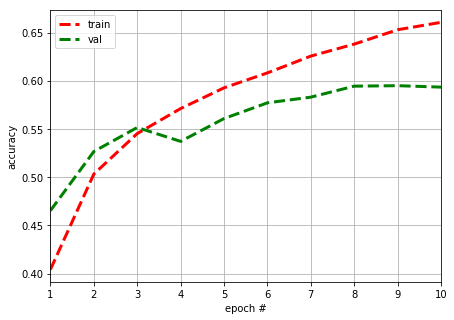

In [53]:
model = Sequential([
    ZeroPadding2D((1, 1), input_shape=(32, 32, 3)),
    Conv2D(10, (3, 3), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),    
    Dense(100, activation='relu'),
    Dense(10, activation='softmax'),
])
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=128, validation_data=[X_val, y_val], callbacks=[gw])

**Задание 1.6 (0.5 балла)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

Выберем ту модель, которая достигала на какой-либо эпохе наилучшую точность.

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 29s - loss: 1.6313 - sparse_categorical_accuracy: 0.4217 - val_loss: 1.3771 - val_sparse_categorical_accuracy: 0.5204
Epoch 2/10
40000/40000 [==============================] - 35s - loss: 1.3066 - sparse_categorical_accuracy: 0.5400 - val_loss: 1.2373 - val_sparse_categorical_accuracy: 0.5650
Epoch 3/10
40000/40000 [==============================] - 37s - loss: 1.1939 - sparse_categorical_accuracy: 0.5815 - val_loss: 1.2244 - val_sparse_categorical_accuracy: 0.5745
Epoch 4/10
40000/40000 [==============================] - 35s - loss: 1.1250 - sparse_categorical_accuracy: 0.6056 - val_loss: 1.1520 - val_sparse_categorical_accuracy: 0.5959
Epoch 5/10
40000/40000 [==============================] - 36s - loss: 1.0665 - sparse_categorical_accuracy: 0.6275 - val_loss: 1.1409 - val_sparse_categorical_accuracy: 0.5997
Epoch 6/10
40000/40000 [==============================] - 35s - loss: 

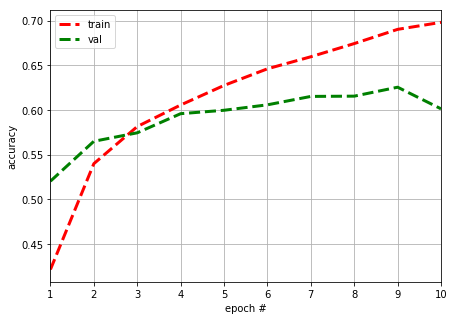

In [56]:
model = Sequential([
    ZeroPadding2D((1, 1), input_shape=(32, 32, 3)),
    Conv2D(10, (3, 3), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),    
    Dense(100, activation='relu'),
    Dense(10, activation='softmax'),
])
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=32, validation_data=[X_val, y_val], callbacks=[gw])

Напишите ваши выводы по проделанным экспериментам: что заработало, что — не очень. Постройте график кривых обучения (здесь или выше) с кривыми обучения разных архитектур.

Хорошо сработала оптимизация Adam и сверточные слои, нормализация по батчу ухудшила результат работы сети.

## Свёрточная нейросеть здорового человека

**Задание 1.7 (5 баллов)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [19]:
from keras.utils import np_utils

#one-hot encode the labels
y_train = np_utils.to_categorical(y_train, 10)
y_val = np_utils.to_categorical(y_val, 10)

Train on 40000 samples, validate on 10000 samples
Epoch 1/250
40000/40000 [==============================] - 300s - loss: 1.3204 - acc: 0.5226 - val_loss: 1.1902 - val_acc: 0.5759
Epoch 2/250
40000/40000 [==============================] - 292s - loss: 1.2376 - acc: 0.5543 - val_loss: 1.1389 - val_acc: 0.5944
Epoch 3/250
40000/40000 [==============================] - 294s - loss: 1.1696 - acc: 0.5818 - val_loss: 1.0860 - val_acc: 0.6191
Epoch 4/250
40000/40000 [==============================] - 294s - loss: 1.1105 - acc: 0.6039 - val_loss: 1.0171 - val_acc: 0.6394
Epoch 5/250
40000/40000 [==============================] - 294s - loss: 1.0604 - acc: 0.6256 - val_loss: 0.9915 - val_acc: 0.6528
Epoch 6/250
40000/40000 [==============================] - 293s - loss: 1.0084 - acc: 0.6462 - val_loss: 0.9500 - val_acc: 0.6602
Epoch 7/250
40000/40000 [==============================] - 288s - loss: 0.9746 - acc: 0.6560 - val_loss: 0.9121 - val_acc: 0.6797
Epoch 8/250
40000/40000 [===============

40000/40000 [==============================] - 292s - loss: 0.1093 - acc: 0.9616 - val_loss: 0.7876 - val_acc: 0.8066
Epoch 116/250
40000/40000 [==============================] - 292s - loss: 0.1092 - acc: 0.9610 - val_loss: 0.8090 - val_acc: 0.8046
Epoch 117/250
40000/40000 [==============================] - 292s - loss: 0.1032 - acc: 0.9631 - val_loss: 0.8196 - val_acc: 0.8030
Epoch 118/250
40000/40000 [==============================] - 292s - loss: 0.1066 - acc: 0.9633 - val_loss: 0.8025 - val_acc: 0.8081
Epoch 119/250
40000/40000 [==============================] - 292s - loss: 0.1041 - acc: 0.9633 - val_loss: 0.8138 - val_acc: 0.8041
Epoch 120/250
39968/40000 [============================>.] - ETA: 0s - loss: 0.0997 - acc: 0.9650
######## Model Dumped ########
40000/40000 [==============================] - 293s - loss: 0.0997 - acc: 0.9650 - val_loss: 0.8586 - val_acc: 0.8014
Epoch 121/250
40000/40000 [==============================] - 292s - loss: 0.1049 - acc: 0.9631 - val_loss: 

40000/40000 [==============================] - 293s - loss: 0.0583 - acc: 0.9803 - val_loss: 0.9264 - val_acc: 0.8100
Epoch 229/250
40000/40000 [==============================] - 292s - loss: 0.0541 - acc: 0.9814 - val_loss: 0.9403 - val_acc: 0.8092
Epoch 230/250
39968/40000 [============================>.] - ETA: 0s - loss: 0.0564 - acc: 0.9806
######## Model Dumped ########
40000/40000 [==============================] - 297s - loss: 0.0563 - acc: 0.9806 - val_loss: 0.9632 - val_acc: 0.8011
Epoch 231/250
40000/40000 [==============================] - 300s - loss: 0.0550 - acc: 0.9819 - val_loss: 0.9206 - val_acc: 0.8105
Epoch 232/250
40000/40000 [==============================] - 295s - loss: 0.0547 - acc: 0.9813 - val_loss: 0.9245 - val_acc: 0.8131
Epoch 233/250
40000/40000 [==============================] - 290s - loss: 0.0562 - acc: 0.9801 - val_loss: 0.9365 - val_acc: 0.8075
Epoch 234/250
40000/40000 [==============================] - 290s - loss: 0.0537 - acc: 0.9816 - val_loss: 

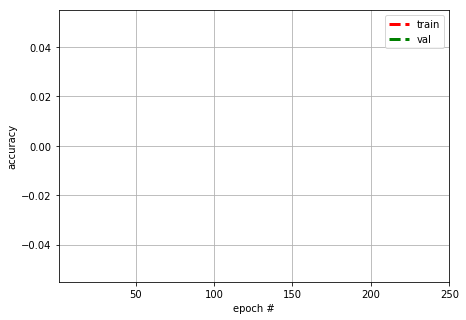

In [24]:
def pure_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=(32, 32, 3)))   
    model.add(Dropout(0.2))
    
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(Dropout(0.5))
    
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))    
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))
    
    
    
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(Dropout(0.5))    
    
    model.add(Conv2D(192, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (1, 1),padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(10, (1, 1), padding='valid'))

    model.add(GlobalAveragePooling2D())
    
    model.add(Activation('softmax'))

    model.summary()
    
    return model

gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001, decay=1e-6),
                  metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=250, validation_data=[X_val, y_val], callbacks=[gw])

Момент истины: проверьте, какого качества достигла ваша сеть.

In [25]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

 9984/10000 [============================>.] - ETA: 0s
 Test_acc = 0.8102
Это победа!


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов. 

# А ниже страдания, как получить 0.8

In [23]:
from keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

    # Compile the model
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001, decay=1e-6),
                  metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=250, validation_data=[X_val, y_val], callbacks=[gw])

Train on 40000 samples, validate on 10000 samples
Epoch 1/250
40000/40000 [==============================] - 301s - loss: 1.8564 - acc: 0.3070 - val_loss: 1.5788 - val_acc: 0.4239
Epoch 2/250
40000/40000 [==============================] - 305s - loss: 1.5234 - acc: 0.4390 - val_loss: 1.3751 - val_acc: 0.4969
Epoch 3/250
19968/40000 [=============>................] - ETA: 140s - loss: 1.4026 - acc: 0.4845

KeyboardInterrupt: 

In [20]:
# попробуем применить больше сверточных фильтров
model = Sequential([
    ZeroPadding2D((1, 1), input_shape=(32, 32, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),    
    Dense(100, activation='relu'),
    Dense(10, activation='softmax'),
])
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, validation_data=[X_val, y_val], callbacks=[gw])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 153s - loss: 1.4864 - acc: 0.4652 - val_loss: 1.2880 - val_acc: 0.5451
Epoch 2/10
40000/40000 [==============================] - 181s - loss: 1.1561 - acc: 0.5931 - val_loss: 1.1046 - val_acc: 0.6158
Epoch 3/10
40000/40000 [==============================] - 187s - loss: 1.0177 - acc: 0.6437 - val_loss: 1.0898 - val_acc: 0.6320
Epoch 4/10
40000/40000 [==============================] - 181s - loss: 0.9245 - acc: 0.6750 - val_loss: 1.0308 - val_acc: 0.6495
Epoch 5/10
40000/40000 [==============================] - 181s - loss: 0.8494 - acc: 0.7007 - val_loss: 1.0224 - val_acc: 0.6563
Epoch 6/10
14016/40000 [=========>....................] - ETA: 117s - loss: 0.7606 - acc: 0.7336

KeyboardInterrupt: 

In [21]:
# попробуем применить больше сверточных фильтров
model = Sequential([
    ZeroPadding2D((1, 1), input_shape=(32, 32, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),    
    Dense(100, activation='relu'),
    Dense(10, activation='softmax'),
])
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, validation_data=[X_val, y_val], callbacks=[gw])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 143s - loss: 1.4983 - acc: 0.4706 - val_loss: 1.2937 - val_acc: 0.5419
Epoch 2/10
40000/40000 [==============================] - 177s - loss: 1.1959 - acc: 0.5823 - val_loss: 1.2045 - val_acc: 0.5785
Epoch 3/10
31680/40000 [======================>.......] - ETA: 37s - loss: 1.0723 - acc: 0.6287

KeyboardInterrupt: 

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 152s - loss: 1.4609 - sparse_categorical_accuracy: 0.4801 - val_loss: 1.2744 - val_sparse_categorical_accuracy: 0.5507
Epoch 2/10
40000/40000 [==============================] - 193s - loss: 1.1642 - sparse_categorical_accuracy: 0.5935 - val_loss: 1.1599 - val_sparse_categorical_accuracy: 0.5977
Epoch 3/10
40000/40000 [==============================] - 192s - loss: 1.0268 - sparse_categorical_accuracy: 0.6375 - val_loss: 1.1067 - val_sparse_categorical_accuracy: 0.6121
Epoch 4/10
40000/40000 [==============================] - 189s - loss: 0.9195 - sparse_categorical_accuracy: 0.6775 - val_loss: 1.1499 - val_sparse_categorical_accuracy: 0.6047
Epoch 5/10
40000/40000 [==============================] - 186s - loss: 0.8348 - sparse_categorical_accuracy: 0.7066 - val_loss: 1.0681 - val_sparse_categorical_accuracy: 0.6385
Epoch 6/10
40000/40000 [==============================] - 184s - 

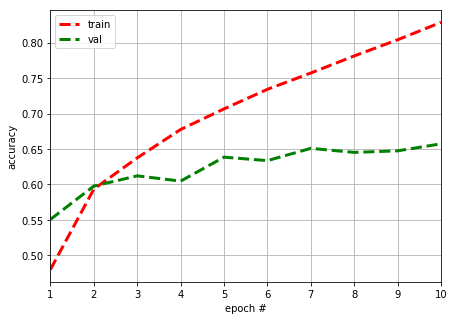

In [57]:
# попробуем применить больше сверточных фильтров
model = Sequential([
    ZeroPadding2D((1, 1), input_shape=(32, 32, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),    
    Dense(100, activation='relu'),
    Dense(10, activation='softmax'),
])
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=32, validation_data=[X_val, y_val], callbacks=[gw])

In [ ]:
from keras.layers import BatchNormalization, ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense

def net():
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(32, 32, 3)))   
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model

model = net()
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=32, validation_data=[X_val, y_val], callbacks=[gw])

In [ ]:
def net():
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(32, 32, 3)))   
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model

model = net()
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=32, validation_data=[X_val, y_val], callbacks=[gw])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 537s - loss: 1.4177 - sparse_categorical_accuracy: 0.4923 - val_loss: 1.1019 - val_sparse_categorical_accuracy: 0.6115
Epoch 2/10
40000/40000 [==============================] - 715s - loss: 1.0407 - sparse_categorical_accuracy: 0.6314 - val_loss: 0.9442 - val_sparse_categorical_accuracy: 0.6641
Epoch 3/10
40000/40000 [==============================] - 724s - loss: 0.8847 - sparse_categorical_accuracy: 0.6874 - val_loss: 0.9166 - val_sparse_categorical_accuracy: 0.6811
Epoch 4/10
16512/40000 [===========>..................] - ETA: 415s - loss: 0.7365 - sparse_categorical_accuracy: 0.7376

In [16]:
from keras.layers import BatchNormalization, ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense

def net():
    model = Sequential()
    
    model.add(ZeroPadding2D((1, 1), input_shape=(32, 32, 3)))    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

model = net()
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=[X_val, y_val], callbacks=[gw])

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 858s - loss: 1.6383 - sparse_categorical_accuracy: 0.3910 - val_loss: 1.2941 - val_sparse_categorical_accuracy: 0.5377
Epoch 2/100
40000/40000 [==============================] - 1044s - loss: 1.2067 - sparse_categorical_accuracy: 0.5665 - val_loss: 1.1108 - val_sparse_categorical_accuracy: 0.6109
Epoch 3/100
40000/40000 [==============================] - 1026s - loss: 1.0100 - sparse_categorical_accuracy: 0.6442 - val_loss: 0.9747 - val_sparse_categorical_accuracy: 0.6642
Epoch 4/100
40000/40000 [==============================] - 1041s - loss: 0.8648 - sparse_categorical_accuracy: 0.6960 - val_loss: 0.9261 - val_sparse_categorical_accuracy: 0.6746
Epoch 5/100
40000/40000 [==============================] - 989s - loss: 0.7525 - sparse_categorical_accuracy: 0.7355 - val_loss: 0.7997 - val_sparse_categorical_accuracy: 0.7249
Epoch 6/100
40000/40000 [==============================] 

KeyboardInterrupt: 

In [ ]:
def net():
    model = Sequential()
    
    model.add(ZeroPadding2D((1, 1), input_shape=(32, 32, 3)))    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))

    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

model = net()
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=32, validation_data=[X_val, y_val], callbacks=[gw])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 3530s - loss: 1.6322 - sparse_categorical_accuracy: 0.3967 - val_loss: 1.3804 - val_sparse_categorical_accuracy: 0.4887
Epoch 2/10
40000/40000 [==============================] - 4663s - loss: 1.2124 - sparse_categorical_accuracy: 0.5674 - val_loss: 1.1060 - val_sparse_categorical_accuracy: 0.6070
Epoch 3/10
40000/40000 [==============================] - 4728s - loss: 1.0350 - sparse_categorical_accuracy: 0.6336 - val_loss: 0.9723 - val_sparse_categorical_accuracy: 0.6489
Epoch 4/10
40000/40000 [==============================] - 4764s - loss: 0.9018 - sparse_categorical_accuracy: 0.6823 - val_loss: 0.9688 - val_sparse_categorical_accuracy: 0.6661
Epoch 5/10
40000/40000 [==============================] - 4742s - loss: 0.8017 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.9234 - val_sparse_categorical_accuracy: 0.6781
Epoch 6/10
40000/40000 [==============================] - 47

In [12]:
from keras.layers import BatchNormalization, ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D

def net():
    model = Sequential()
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=(32, 32, 3)))    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(Dropout(0.5))
    
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))    
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(Dropout(0.5))    
    
    model.add(Conv2D(192, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (1, 1),padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(10, (1, 1), padding='valid'))

    model.add(GlobalAveragePooling2D())
    
    model.add(Activation('softmax'))
    return model

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model = net()
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=300, validation_data=[X_val, y_val], callbacks=[gw])

Train on 40000 samples, validate on 10000 samples
Epoch 1/300
 7392/40000 [====>.........................] - ETA: 1386s - loss: 2.3044 - sparse_categorical_accuracy: 0.0977

KeyboardInterrupt: 

In [13]:
def vgg11():
    model = Sequential()
    
    model.add(ZeroPadding2D((1, 1), input_shape=(32, 32, 3)))    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))

    model.add(Flatten())
    model.add(Dense(3000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model

model = vgg11()
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=300, validation_data=[X_val, y_val], callbacks=[gw])

Train on 40000 samples, validate on 10000 samples
Epoch 1/300
 7200/40000 [====>.........................] - ETA: 9923s - loss: 2.3501 - sparse_categorical_accuracy: 0.0965

KeyboardInterrupt: 

In [18]:
model = ResnetBuilder.build_resnet_18((3, 32, 32), 10)
gw = GlobalWotcher(acc=True, react_time=1000, dump_p=10, base_path="./calc")
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=300, validation_data=[X_val, y_val], callbacks=[gw])

Train on 40000 samples, validate on 10000 samples
Epoch 1/300
40000/40000 [==============================] - 1622s - loss: 1.8549 - sparse_categorical_accuracy: 0.5006 - val_loss: 2.2751 - val_sparse_categorical_accuracy: 0.3802
Epoch 2/300
40000/40000 [==============================] - 3573s - loss: 1.3914 - sparse_categorical_accuracy: 0.6290 - val_loss: 1.4491 - val_sparse_categorical_accuracy: 0.6089
Epoch 3/300
40000/40000 [==============================] - 3566s - loss: 1.2014 - sparse_categorical_accuracy: 0.6842 - val_loss: 1.3929 - val_sparse_categorical_accuracy: 0.6266
Epoch 4/300
40000/40000 [==============================] - 3587s - loss: 1.0894 - sparse_categorical_accuracy: 0.7220 - val_loss: 1.6315 - val_sparse_categorical_accuracy: 0.5747
Epoch 5/300
40000/40000 [==============================] - 3651s - loss: 1.0025 - sparse_categorical_accuracy: 0.7532 - val_loss: 1.1646 - val_sparse_categorical_accuracy: 0.7080
Epoch 6/300
40000/40000 [==============================

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-268e59063502>", line 4, in <module>
    model.fit(X_train, y_train, batch_size=32, epochs=300, validation_data=[X_val, y_val], callbacks=[gw])
  File "/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 1507, in fit
    initial_epoch=initial_epoch)
  File "/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 1156, in _fit_loop
    outs = f(ins_batch)
  File "/anaconda3/lib/python3.6/site-packages/keras/backend/theano_backend.py", line 1196, in __call__
    return self.function(*inputs)
  File "/anaconda3/lib/python3.6/site-packages/theano/compile/function_module.py", line 903, in __call__
    self.fn() if output_subset is None else\
  File "/anaconda3/lib/python3.6/site-packages/theano/gof/op.py", line 891, in rval
    def rval(p=p, 

KeyboardInterrupt: 

In [17]:
import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])